## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
import tensorflow as tf

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot
from library.utils import file_utils
from library.tf.models.linear_classifier import LinearClassifier

## Select Tensorflow device

In [4]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [5]:
total_time = 0

## Experiment

In [6]:
exp_no = 1
data_source = 'Website'
num_images_required = 1.0
file_no = 101

### Parameters for experiment

In [7]:
device_name = '/gpu:0'
learn_rate = 0.01
train_epochs = 100
display_step = 1
reg_const = 0.01
train_val_split_data = None
train_val_split = 0.8
transform = True
transform_method = 'StandardScaler'
learn_rate_type = 'constant'
dataset = 'cifar10'
descent_methods = ['adam', 'gradient', 'adaprop', 'rmsprop', 'adadelta', 'momentum']

### Log directories

In [8]:
log_dirs = []
log_files = []
model_files = []

In [9]:
for index, descent_method in enumerate(descent_methods):
    log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(3) + '_tf_linear_raw_gradtest/exp_no_' + str(index+1).zfill(3) + '/'
    log_file = log_dir + 'linear_classifier.ckpt'
    model_file = log_dir + 'linear_classifier.pb'
    log_dirs.append(log_dir)
    log_files.append(log_file)
    model_files.append(model_file)
    print('Writing tensorboard logs to %s' % log_file)
    print('View logs by running tensorboard: ', end='')
    print('\"tensorboard --logdir=\'./%s/101_tf_linear_raw_gradtest/\' --port 61111\"' %dataset)

Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw_gradtest/exp_no_001/linear_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/101_tf_linear_raw_gradtest/' --port 61111"
Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw_gradtest/exp_no_002/linear_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/101_tf_linear_raw_gradtest/' --port 61111"
Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw_gradtest/exp_no_003/linear_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/101_tf_linear_raw_gradtest/' --port 61111"
Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw_gradtest/exp_no_004/linear_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/101_tf_linear_raw_gradtest/' --port 61111"
Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw_gradtest/exp_no_005/linear_classifier.ckpt
View logs by running tensorboard: "

## Step 1: Load CIFAR 10 Dataset

In [10]:
start = time.time()
one_hot = True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, preprocess='StandardScaler',
                  train_validate_split=train_val_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 1] Loaded CIFAR 10 Dataset in %.4f ms' %((end-start)*1000))
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 5.7875 seconds
[ Step 1] Loaded CIFAR 10 Dataset in 5788.6543 ms


In [11]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_val_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test class labels shape: (10000,)


In [12]:
print('Training images')
print(cifar10.train.data[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[-0.977 -1.203 -1.122 ...,  0.403 -0.459 -0.641]
 [ 0.317 -0.057 -0.361 ...,  0.388  0.431  0.448]
 [ 1.693  1.696  1.688 ..., -0.475 -0.474 -0.46 ]
 [-1.399 -1.286 -1.288 ..., -1.323 -1.179 -1.035]
 [ 0.535  0.523  0.636 ..., -0.491 -0.551 -0.52 ]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[ 0.375  0.401  0.468 ...,  0.142  0.219 -0.081]
 [ 1.425  1.395  1.395 ...,  0.98   1.174  1.274]
 [ 0.375  0.387  0.109 ..., -1.658 -1.722 -1.65 ]
 [ 0.334  0.511  0.621 ..., -1.006 -0.967 -0.995]
 [-0.894 -0.829 -1.15  ...,  0.328  0.481  0.025]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  

## Step 1.1 Load sample images

Plotting CIFAR 10 Train Dataset


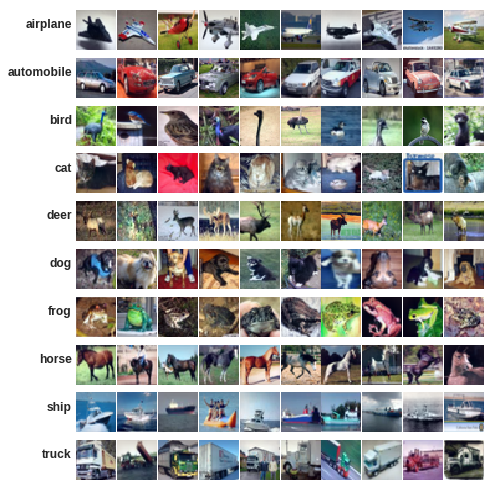

Plotting CIFAR 10 Test Dataset


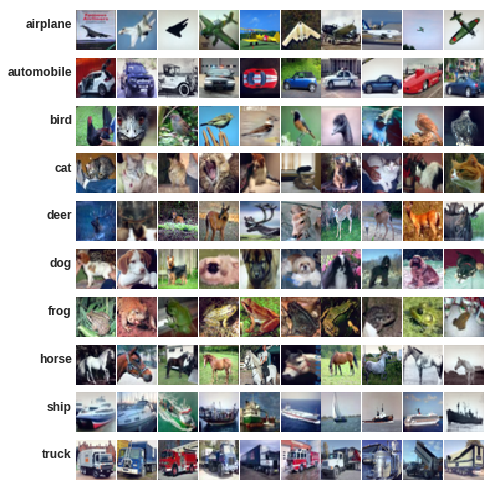

In [13]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

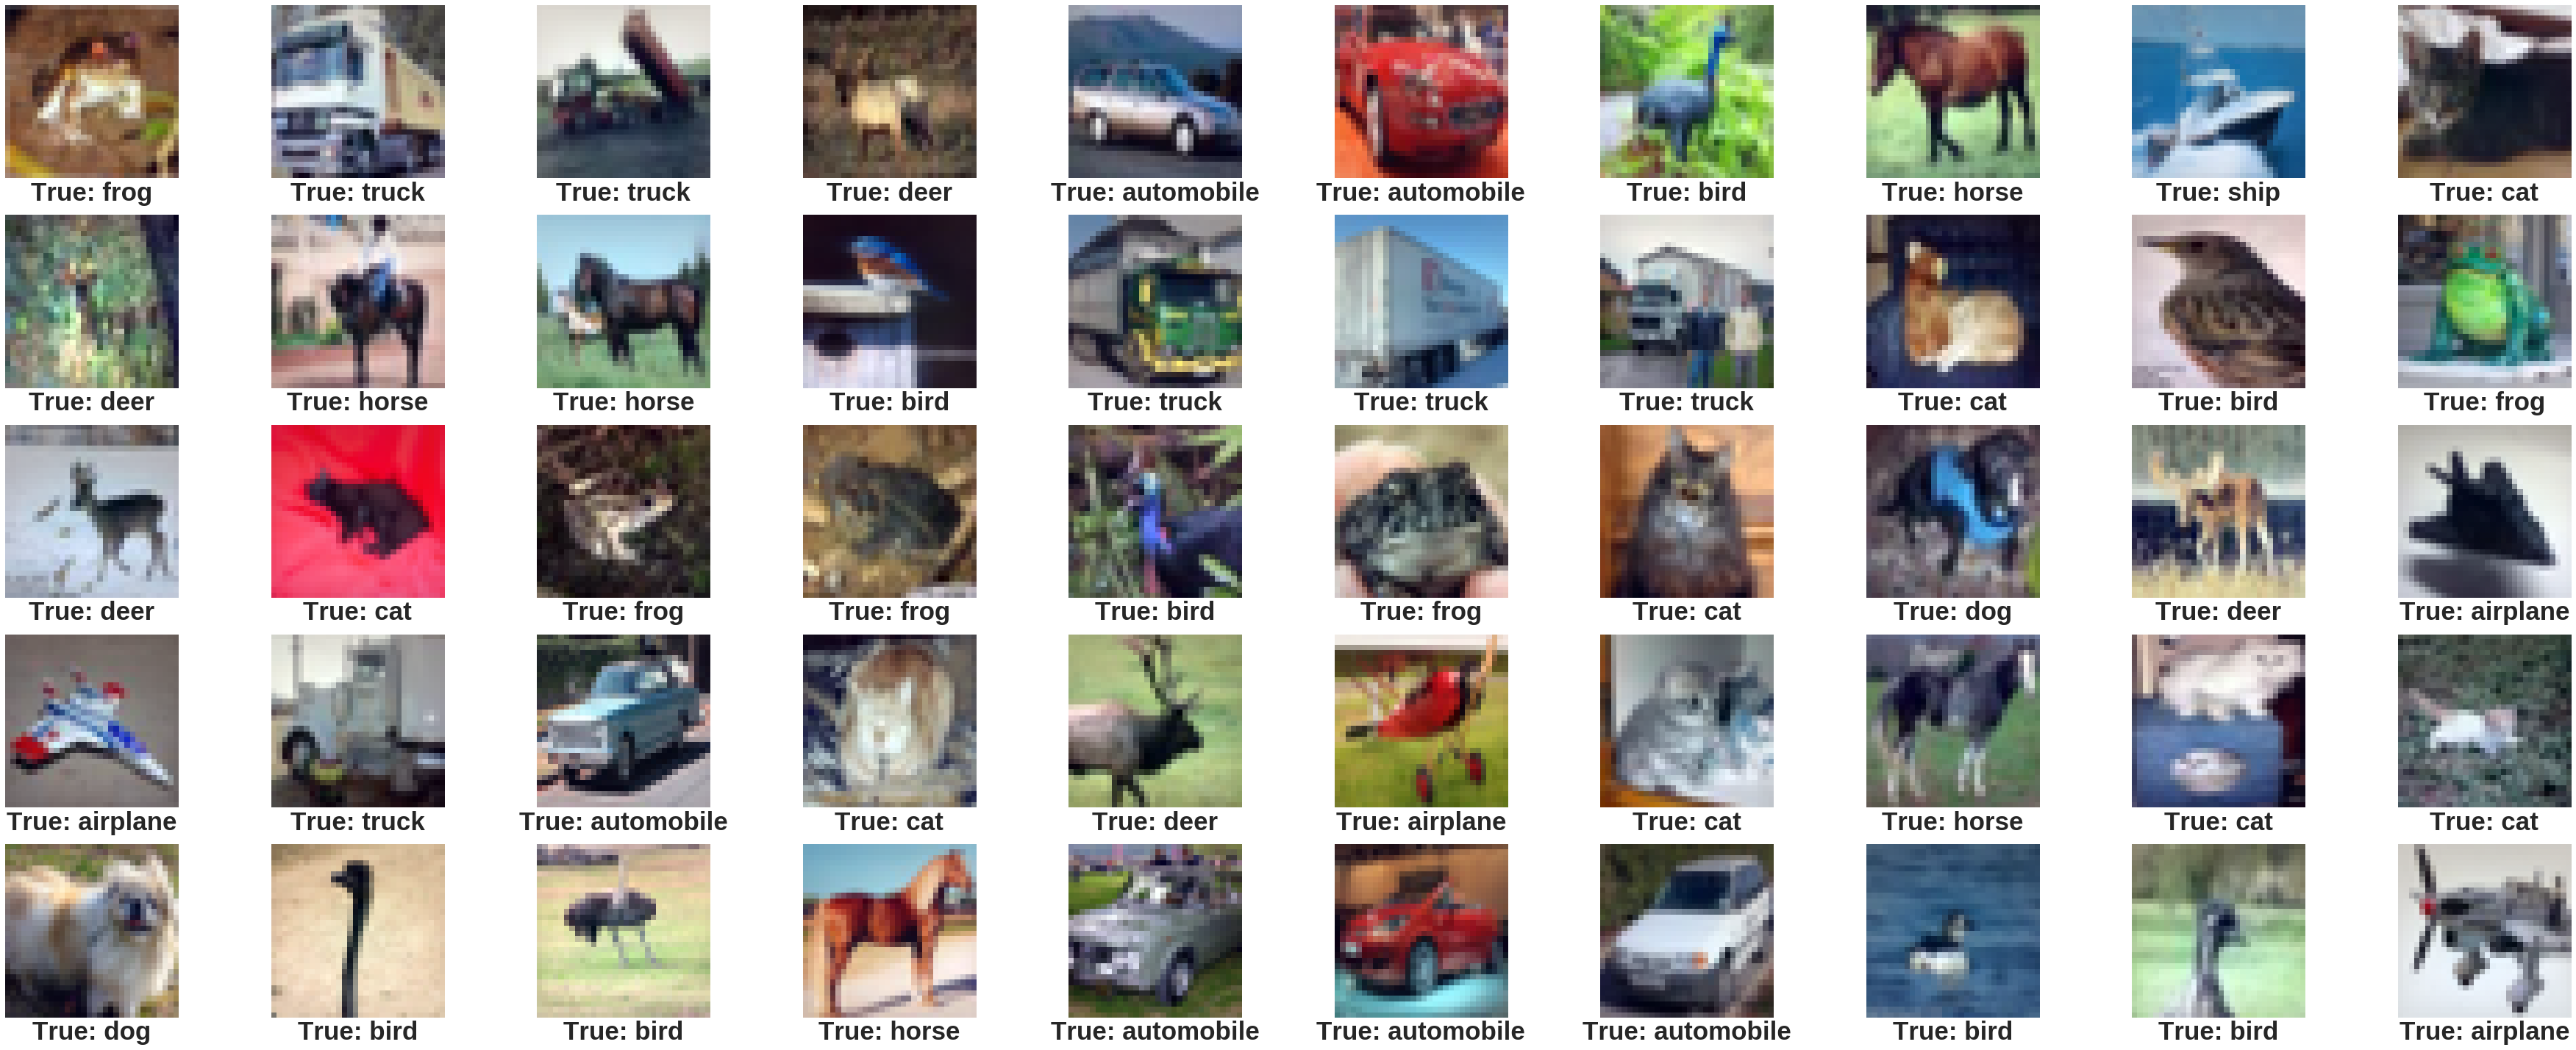

True

In [14]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Linear Regression

### Step 2.1: Model linear regression y = Wx + b

In [15]:
num_features = cifar10.train.data.shape[1]
num_classes = 10

In [16]:
net_configs = []
for index, descent_method in enumerate(descent_methods):
    network_config = {'weight': {'type': 'zeros', 'name': 'Weight'},
                      'bias': {'type': 'ones', 'name': 'Bias'},
                      'activation_fn': 'relu',
                      'descent_method': descent_method}
    net_configs.append(network_config)

In [17]:
lcs = []
for index, descent_method in enumerate(descent_methods):
    lc = LinearClassifier(verbose=False, device=device_name, session_type='interactive', num_iter=train_epochs, 
                          err_tolerance=1e-7, train_validate_split=train_val_split, display_step=display_step,
                          learn_step=10, learn_rate_type=learn_rate_type, learn_rate=learn_rate, reg_const=reg_const, 
                          logs=True, log_dir=log_dirs[index], test_log=True, save_model=True, 
                          checkpoint_filename=log_files[index], 
                          save_checkpoint=True, restore=False, model_name=model_files[index], config=net_configs[index])
    lcs.append(lc)

### Step 2.2: Create the tensorflow graph

In [18]:
start = time.time()
for index, descent_method in enumerate(descent_methods):
    lcs[index].create_graph(num_features=num_features, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f1012c7acf8>
Model has been trained for 0 iterations
Tensorflow graph created in 0.9352 seconds
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f100509de80>
Model has been trained for 0 iterations
Tensorflow graph created in 0.5989 seconds
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f100d0f56a0>
Model has been trained for 0 iterations
Tensorflow graph created in 0.4127 seconds
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f100d0d4a58>
Model has been trained for 0 iterations
Tensorflow graph created in 0.5035 seconds
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f1004e39860>
Model has been trained for 0 iterations
Tensorflow graph created in 0.6852 seconds
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f100c418cc0>
Model has been trained for 0 iterations
Tensorflow graph 

In [19]:
for index, descent_method in enumerate(descent_methods):
    lcs[index].print_parameters()

Parameters for Linear classifier
>> Input Parameters
Input                  : Tensor("Inputs/Data/X_input:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0) 
True one hot labels    : Tensor("Inputs/Train_Labels/y_true_one_hot_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
True class             : Tensor("Inputs/Train_Labels/y_true_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Predict one hot labels : Tensor("Predictions/one_hot:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
Predict class          : Tensor("Predictions/predict_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
>> Model params
last_successful_epoch/initial_value
last_successful_epoch
last_successful_epoch/Assign
last_successful_epoch/read
add/y
add
assign_updated_epoch
Inputs/Data/X_input
Inputs/Train_Labels/y_true_one_hot_label
Inputs/Train_Labels/y_true_class
Parameters/Weights/zeros
Parameters/Weights/Weight
Parameters/Weights/Weight/Assign
Parameters/Weights/Weight/

### Step 2.3: Fit the model/training

In [20]:
for index, descent_method in enumerate(descent_methods):
    lcs[index].fit(cifar10.train.data, cifar10.train.one_hot_labels, cifar10.train.class_labels,
                   test_data=cifar10.test.data, test_labels=cifar10.test.one_hot_labels, 
                   test_classes=cifar10.test.class_labels)

Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [  0/100]
train_loss: 2.3026 | train_acc: 0.1004 | val_loss: 2.3007 | val_acc: 0.2434 | test_acc: 0.2571 | Time: 1.3915 s
>>> Epoch [  1/100]
train_loss: 2.3006 | train_acc: 0.2498 | val_loss: 2.2987 | val_acc: 0.2433 | test_acc: 0.2565 | Time: 1.0060 s
>>> Epoch [  2/100]
train_loss: 2.2985 | train_acc: 0.2492 | val_loss: 2.2966 | val_acc: 0.2429 | test_acc: 0.2561 | Time: 1.0030 s
>>> Epoch [  3/100]
train_loss: 2.2964 | train_acc: 0.2483 | val_loss: 2.2944 | val_acc: 0.2425 | test_acc: 0.2559 | Time: 1.1103 s
>>> Epoch [  4/100]
train_loss: 2.2942 | train_acc: 0.2473 | val_loss: 2.2921 | val_acc: 0.2423 | test_acc: 0.2538 | Time: 0.9826 s
>>> Epoch [  5/100]
train_loss: 2.2918 | train_acc: 0.2465 | val_loss: 2.2897 | val_acc: 0.2416 | test_acc: 0.2516 | Time: 0.9726 s
>>> 

### Step 2.4: Make the predictions

In [21]:
# prediction_numbers = lc.predict(cifar10.test.data)
# prediction_classes = []
# num_test_images = cifar10.test.data.shape[0]
# for i in range(num_test_images):
#     prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

In [22]:
# cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
#                     nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

### Step 2.5: Print the results

In [23]:
for index, descent_method in enumerate(descent_methods):
    test_accuracy = lcs[index].score(cifar10.test.data, cifar10.test.class_labels)
    print('Accuracy of the linear classifier on test dataset using %s: %.4f' % (descent_method, test_accuracy))

Accuracy of the linear classifier on test dataset using adam: 0.3126
Accuracy of the linear classifier on test dataset using gradient: 0.3094
Accuracy of the linear classifier on test dataset using adaprop: 0.3127
Accuracy of the linear classifier on test dataset using rmsprop: 0.3126
Accuracy of the linear classifier on test dataset using adadelta: 0.3124
Accuracy of the linear classifier on test dataset using momentum: 0.3131


In [24]:
# lc.print_classification_results(cifar10.test.data, cifar10.test.one_hot_labels, cifar10.test.class_labels,
#                                 test_class_names=cifar10.classes, normalize=True)

### Step 2.6: Plot results

In [25]:
for index, descent_method in enumerate(descent_methods):
    if index == 0:
        train_losses = lcs[index].out_params['list_train_loss']
        val_losses = lcs[index].out_params['list_val_loss']
        train_acc = lcs[index].out_params['list_train_acc']
        val_acc = lcs[index].out_params['list_val_acc']
    else:
        train_losses = np.vstack((train_losses, lcs[index].out_params['list_train_loss']))
        val_losses = np.vstack((val_losses, lcs[index].out_params['list_val_loss']))
        train_acc = np.vstack((train_acc, lcs[index].out_params['list_train_acc']))
        val_acc = np.vstack((val_acc, lcs[index].out_params['list_val_acc']))

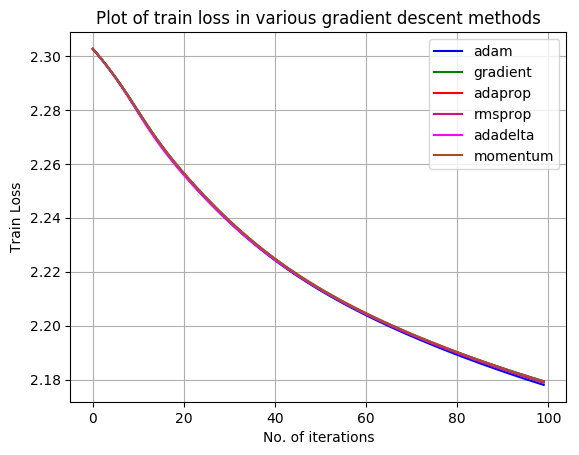

In [26]:
colors = []
plot.plot_scores(train_losses, legend=descent_methods, colors=colors,
                 plot_title='Plot of train loss in various gradient descent methods',
                 plot_xlabel='No. of iterations', plot_ylabel='Train Loss')

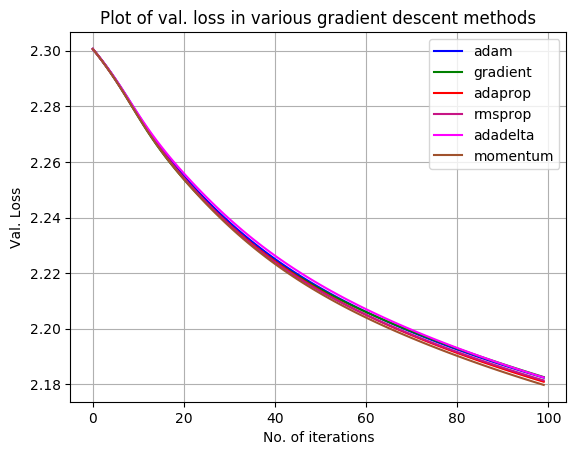

In [27]:
colors = []
plot.plot_scores(val_losses, legend=descent_methods, colors=colors,
                 plot_title='Plot of val. loss in various gradient descent methods',
                 plot_xlabel='No. of iterations', plot_ylabel='Val. Loss')

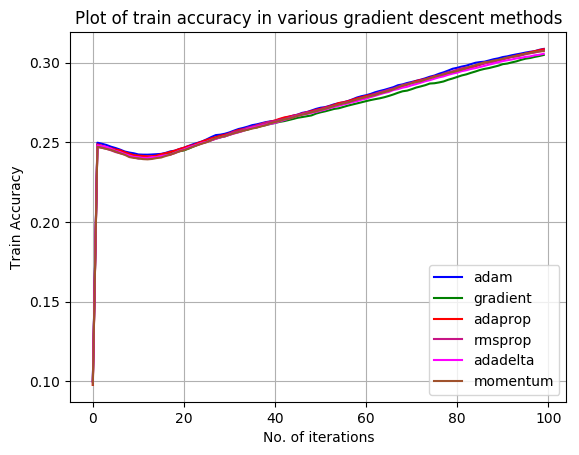

In [33]:
colors = []
plot.plot_scores(train_acc, legend=descent_methods, colors=colors,
                 plot_title='Plot of train accuracy in various gradient descent methods',
                 plot_xlabel='No. of iterations', plot_ylabel='Train Accuracy')

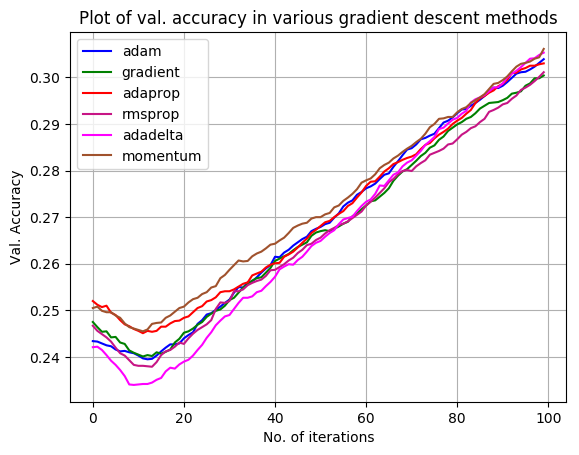

In [34]:
colors = []
plot.plot_scores(val_acc, legend=descent_methods, colors=colors,
                 plot_title='Plot of val. accuracy in various gradient descent methods',
                 plot_xlabel='No. of iterations', plot_ylabel='Val. Accuracy')

Plot for descent method: adam


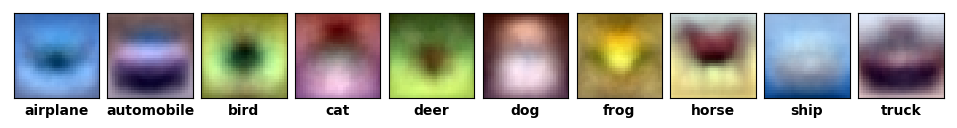

Plot for descent method: gradient


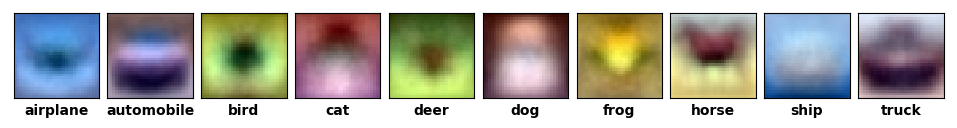

Plot for descent method: adaprop


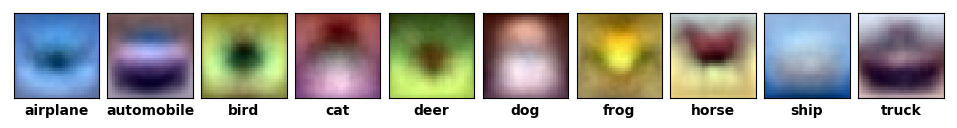

Plot for descent method: rmsprop


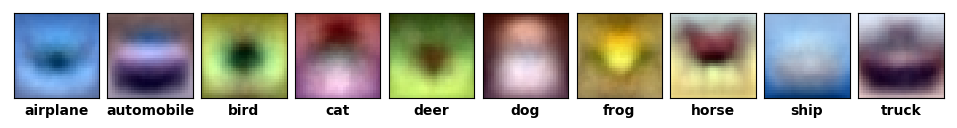

Plot for descent method: adadelta


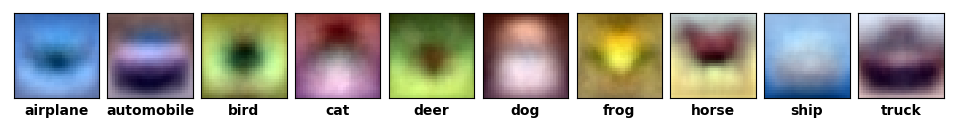

Plot for descent method: momentum


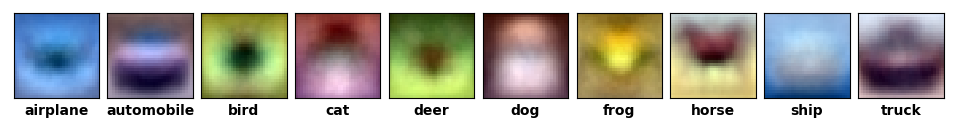

In [31]:
for index, descent_method in enumerate(descent_methods):
    print('Plot for descent method: %s' % descent_method)
    lcs[index].plot_weights(classes=cifar10.classes)

### Step 2.7: Close the session

In [32]:
for index, descent_method in enumerate(descent_methods):
    lcs[index].close()

AssertionError: Nesting violated for default stack of <class 'tensorflow.python.client.session.InteractiveSession'> objects

## Step 3: Write to file

In [ ]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [ ]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
current_file = './' + theNotebook + '.ipynb'
for index, descent_method in enumerate(descent_methods):
    output_file = log_dirs[index] + str(file_no).zfill(3) + '_exp_no_' + str(index+1).zfill(3) + '_' + theNotebook + '.html'
    print('Current file: ' + str(current_file))
    print('Output file: ' + str(output_file))
    file_utils.mkdir_p(log_dirs[index]) 
    output_HTML(current_file, output_file)